# Theory and Practice of Markov Chain Monte Carlo

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Motivation

MCMC is a computational tool to solve the following problem: suppose you can calculate a function $p(\theta)$ that is proportional to a probability density but do not know its normalization,
$$
\text{prob}(\theta) = \frac{1}{N} p(\theta) \quad, \quad N = \int p(\theta)\,d\theta \; ,
$$
how can you calculate integrals like
$$
\langle f(\theta)\rangle = \frac{1}{N} \int p(\theta) f(\theta)\, d\theta \; .
$$
The argument $\theta$ is typically a vector of real-valued model parameters. An alternative method for solving this problem is [variational inference](https://arxiv.org/abs/1601.00670).

This problem is central to Bayesian inference, where the relevant probability density is the posterior
$$
P(\theta\,|\,D) = \frac{P(D\,|\,\theta) P(\theta)}{P(D)}
$$
but we generally only know how to calculate its numerator, the product of the likelihood and prior,
$$
p(\theta) = P(D\,|\,\theta) P(\theta)
$$
but not its denominator, the evidence
$$
N = P(D) = \int P(D\,|\,\theta) P(\theta)\, d\theta \; .
$$
Integrals like $\langle f(\theta)\rangle$ are required to estimate the mean values and covariances of parameters and to marginalize out nuisance parameters.

## Theory of Markov Chains

A Markov chain is a sequence of randomly generated parameter values:
$$
\theta_0\rightarrow \theta_1\rightarrow \theta_2\rightarrow \ldots
\rightarrow \theta_{N-1}\rightarrow \theta_N\rightarrow \ldots
$$
where the probability of obtaining $\theta$ at step $N$ only depends on the previous value $\theta_{N-1}$ and not on any earlier values. In other words, the chain has no memory.

In general, the probability also depends on $N$, unless the chain is **time homogeneous** (but most practical MCMC schemes do dependend on $N$).

If $\theta$ is limited to a finite set of values, we can think of $\theta$ as a state label and the chain as a sequence of state transitions.  If the chain is also **time homogeneous**, the state transition probabilities can be represented as a matrix, e.g., with three states $A, B, C$:
$$
T = \begin{pmatrix}
p_{AA} & p_{AB} & p_{AC} \\
p_{BA} & p_{BB} & p_{BC} \\
p_{CA} & p_{CB} & p_{CC}
\end{pmatrix} \; .
$$
Note that probabilities sum to one along each row (but not down each column). If we represent the states with vectors
$$
A = \begin{pmatrix}1\\ 0\\ 0\end{pmatrix} \quad, \quad
B = \begin{pmatrix}0\\ 1\\ 0\end{pmatrix} \quad, \quad
C = \begin{pmatrix}0\\ 0\\ 1\end{pmatrix} \; ,
$$
then each step in the chain has probabilities
$$
\theta_{N}^t = \theta_{N-1}^t T  \; ,
$$
and multiple steps are given by matrix multiplication
$$
\theta_N^t = \theta_0^t T^N \; .
$$

In [2]:
def generate_random_transition_matrix(n):
    T = np.random.uniform(size=(n, n))
    return T / T.sum(axis=1)[:, np.newaxis]

In [3]:
def plot_markov_chain(T, N):
    n = len(T)
    fig, axes = plt.subplots(nrows=1, ncols=N, sharex=True, sharey=False, squeeze=True, figsize=(15., 15. / N))
    TN = T.copy()
    for ax in axes:
        ax.imshow(TN, interpolation='none', origin='upper', extent=(0., 1., 0., 1.), cmap='viridis')
        ax.set_axis_off()
        TN = TN.dot(T)
    plt.subplots_adjust(wspace=0.05)

Display transition probabilities $T^N$ after $N=1-10$ steps of a finite (time homogeneous) Markov chain. Row $i$ shows the probability of ending in each state $j$ starting from state $i$.

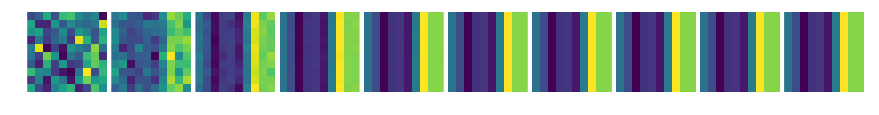

In [4]:
plot_markov_chain(generate_random_transition_matrix(10), 10)

Vertical stripes appear because the chain has converged to a stationary distribution that does not depend on the initial state. This is a generic feature of a randomly chosen $T$.  The vector $\theta_s$ of stationary distribution probabilities is a left eigenvector of $T$:
$$
\theta_s^t = \theta_s^t T \; .
$$

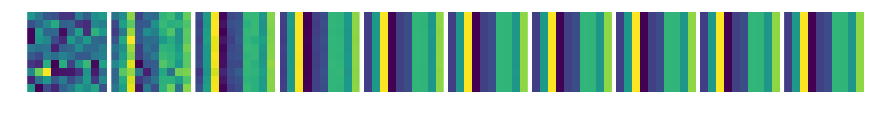

In [5]:
plot_markov_chain(generate_random_transition_matrix(10), 10)

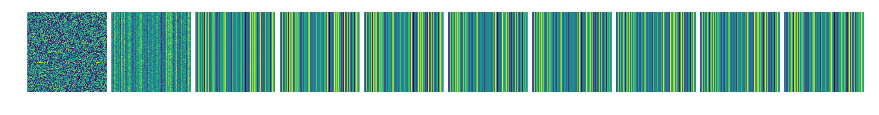

In [6]:
plot_markov_chain(generate_random_transition_matrix(100), 10)

A Markov chain has a unique stationary distribution under some general conditions (more formal details [here](https://en.wikipedia.org/wiki/Markov_chain#Properties)):
1. **irreducible**: every state is reachable from every other state.
2. **aperiodic**: $T^N$ has no zero matrix elements for large $N$.
3. **positive recurrent**: expect to return to any state after finite number of steps.

A **positive recurrent** and **aperiodic** chain is **ergodic**.

In order to use a Markov chain to generate an arbitrary distribution, we need to solve a difficult inverse problem: given a distribution, construct transition probabilities that converge to this distribution.  There are 3 main practical sampling schemes for accomplishing this:
1. Gibbs
2. Metropolis-Hastings
3. Hamiltonian

## Markov Chain Sampling Methods

Call the PDF we want to sample $P(x_1,x_2,\ldots,x_N)$.  It might be a Bayesian posterior $P(\theta|D)$ with $x = \theta$, but this is not necessary (and the dataset $D$ is an internal detail that the sampler does not know about).

### Gibbs Sampling

A conceptually simple scheme is to break our N-dimensional sampler into N 1D-samplers, where each 1D sampler picks a random $x_j$ from the conditional distribution:
$$
P(x_j|x_1,x_2,\ldots,x_{j-1}\;,\;x_{j+1},\ldots,x_{N})
$$

For example, in 2D, we alternate between sampling from $P(x_1|x_2)$ and $P(x_2|x_1)$ to generate a Markov chain: 
$$
(x_1^{(0)},x_2^{(0)}) \rightarrow (x_1^{(1)},x_2^{(1)})\rightarrow \ldots (x_1^{(n)},x_2^{(n)})
$$

1. Pick a starting point $(x_1^{(0)},x_2^{(0)})$.
2. Draw a random $x_1^{(1)}$ from $P(x_1 | x_2^{(0)})$.
3. Draw a random $x_2^{(1)}$ from $P(x_2 | x_2^{(1)})$. Note that we use the updated $x_2^{(1)}$ here!
4. Draw a random $x_1^{(2)}$ from $P(x_1 | x_2^{(1)})$.
5. Draw a random $x_2^{(2)}$ from $P(x_2 | x_2^{(2)})$. Note that we use the updated $x_2^{(2)}$ here!
6. etc

Gibbs sampling is good when you know how to calculate and sample from the conditional distributions, but this isn't always true.  In practice Gibbs sampling, requires that you only use PDFs that factorize:
$$
P(x) = P(x_1) P(x_2) \ldots P(x_N)
$$
or else that you write custom code.  Note that you can Gibbs sample sub-groups of parameters and don't have to go all the way down to 1D.

### Metropolis-Hastings Sampling

Pick a ``proposal distribution'' of transition probabilities $Q(x'|x)$ that is easier to sample than $P(x)$. Starting from $x$, generate a new point $x'$ by sampling from $Q(x'|x)$ and accept the new point with a probability:
$$
    \min\left(1, \frac{P(x')}{P(x\,)}\, \frac{Q(x\,|x')}{Q(x'|x\,)}\right) \; .
$$

If we don't accept the new point, stick with the original point $x$.  This means that runs of repeated points are expected (unlike Gibbs sampling) and required for the correct statistics but bad for efficiency.  On the plus side, MH updates all parameters in a single update, unlike Gibbs.

The algorithm is correct for any proposal distribution, but picking a good one has a huge impact on efficiency.  Most implementations use some sort of multidimensional Gaussian for $Q$, and often update $Q$ on the fly, which violates the **time homogeneous** condition.

A popular choice is $Q(x|x') = Q(x'|x)$, in which case the chain is **reversible** and satisfies the condition of **detailed balance**.  This also simplifies the acceptance probability to:
$$
    \min\left(1, \frac{P(x')}{P(x\,)}\right) \; ,
$$
and means that we always accept a step to higher probability density, $P(x') > P(x)$.  However, the resulting chain is now a **random walk** that is relatively inefficient.

A reversible $Q$ is a sufficient but not necessary condition for the chain to reproduce the desired $P$ (although the book claims otherwise).  As a simple alternative, consider a $Q(x'|x)$ that is ``absolute'', i.e., it does not depend on the previous value $x$.  In this case, the acceptance probability is:
$$
    \min\left(1, \frac{P(x')}{P(x\,)}\, \frac{Q(x\,)}{Q(x')}\right) \; ,
$$
and you can immediately see that we sample $P(x)$ exactly if $Q = P$.

#### Affine Invariant Samplers

[Goodman & Weare, "Ensemble Samplers with Affine Invariance" (2010)](http://dx.doi.org/10.2140/camcos.2010.5.65) describes an afterburner that can be layered on top of MH sampling to achieve **affine invariance**, which basically makes sampling long skinny PDFs as efficient as nice round PDFs.  The [emcee](http://dan.iel.fm/emcee/current/) python package implements this method.

### Hamiltonian Sampling

HMC has only recently become popular and relies on a nifty physics analogy.  A good overview is [here](http://arxiv.org/abs/1206.1901v1).

First, a classical mechanics refresher.  The equations of motion for a system with Hamiltonian $H$ are:
$$
\frac{d q_i}{dt} = +\frac{\partial H}{\partial p_i} \quad , \quad
\frac{d p_i}{dt} = -\frac{\partial H}{\partial q_i} \; ,
$$
where $q_i$ and $p_i$ are the position and momentum of particle $i$.  The Hamiltonian of actual systems can often be written:
$$
H(q,p) = U(q) + K(p)
$$
with an arbitrary potential energy $U(q)$ that only depends on positions and a known kinetic energy that only depends on momenta and masses:
$$
K(p) = \sum_i \frac{p_i^2}{2 m_i} \; .
$$
This leads to simpler equations of motion:
$$
\frac{d q_i}{dt} = \frac{p_i}{m_i} \quad , \quad
\frac{d p_i}{dt} = -\frac{\partial U}{\partial q_i} \; .
$$

We turn Hamiltonian dynamics into a Markov chain by:
1. Identify positions $q_i$ with the parameters $x_i$ we wish to sample.
2. Create new parameters for the corresponding momenta $p_i$. We will treat these as nuiscance parameters, but this doesn't look promising since we just doubled the dimension of our sampling space!
3. Pick a random starting point then follow its evolution according to Hamiltonian dynamics.

Each time we repeat step 3, we add a new point $(q,p)$ to the chain.  Total energy $H$ is conserved and the distribution of the resulting $q$ values is given by the canonical distribution from statistical mechanics:
$$
\text{prob}(q) \propto \exp(-U(q)/(kT)) \; .
$$
Therefore, pick a "potential energy" of:
$$
U(q) = -\log P(q)
$$
to recover the distribution we actually want

In practice, you can usually set the temperature $kT$ and all masses $m_i$ equal to 1 and this works surprisingly well.  The disadvantage is that the method is relatively complex to implement and (even if you use someone else's implementation) requires that you can evaluate derivatives of your $\log P(q)$.

The [pymc3](https://github.com/pymc-devs/pymc3) python package implements HMC, where they call it NUTS.  Note that the book uses pymc2 for its MCMC examples, but the newer version has changed a lot.

This paper gives an amazing example of using HMC to reconstruct the history of matter in the universe! [Jasche, Leclercq, Wandelt, "Past and present cosmic structure in the SDSS DR7 main sample" (2014)](http://arxiv.org/abs/1409.6308):

- $\simeq 10^6$ parameters specifying the 3D matter density at $z \simeq 1000$ with Gaussian prior probability.
- Use 2LPT to model evolution to present.
- Likelihood based on comparison of evolved density field with SDSS galaxy catalog.
- Each new sample takes ~30 minutes to calculate on 16 cores.
- Total analysis took several months and produced 12K samples (~3 Tb)

HMC suffers from the same random-walk behaviour as reversible MH, but a [recent paper](http://arxiv.org/abs/1409.5191) describes a clever way to work around this.

### Comments

All methods require a "burn-in" period to forget their arbitrary initial state and settle into their stationary distribution.  Theory does not provide useful limits on the amount of burn in required, so this part of the algorithm is usually quite ad hoc.

Successive samples are correlated (by design!) so you cannot use the resulting chain as a black-box random number generator.  However, if you just want to do parameter estimation or marginalization, this isn't a problem.  Otherwise, you can "thin" your chain to make the correlations smaller.

These [animations](http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/) compare the three sampling methods with some nice visualizations.